# Times Series for Machine Learning
## Homework 1
- Adhemar SENNEVILLE : adhemar.senneville@gmail.com
- Baptiste CALLARD : baptcallard@gmail.com

# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis="x", tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [3]:
def autocovariance(x, tau):
    if tau == 0:
        return np.dot(x, x) / len(x)
    else:
        tau = abs(tau)
        return np.dot(x[:-tau], x[tau:]) / len(x)


def J(x, f, f_s):
    n = np.arange(len(x))
    exp_term = np.exp(-2j * np.pi * f * n / f_s)
    return (1 / len(x)) * abs(np.dot(x, exp_term) ** 2)


def compute_autocov_and_perdiodograms(N, n_simu, f_s):
    autocovs = np.zeros((n_simu, 2 * N + 1))
    periodograms = np.zeros((n_simu, N // 2))
    taus_autocovs = range(-N, N + 1, 1)
    freqs_periodograms = np.arange(0, N // 2, 1) * f_s / N

    for i in range(n_simu):
        x = np.random.normal(0, 1, N)
        for tau in taus_autocovs:
            autocovs[i, N + tau] = autocovariance(x, tau)

        for j, f in enumerate(freqs_periodograms):
            periodograms[i, j] = J(x, f, f_s)

    return autocovs, periodograms, taus_autocovs, freqs_periodograms


def plot_autocovariance_and_periodigram(N, n_simu, f_s):
    (
        autocovs,
        periodograms,
        taus_autocovs,
        freqs_periodograms,
    ) = compute_autocov_and_perdiodograms(N, n_simu, f_s)
    _, ax = fig_ax(figsize=(9, 5))

    avg = autocovs.mean(axis=0)
    std = autocovs.std(axis=0)
    ax.plot(taus_autocovs, avg, "k-")
    ax.fill_between(taus_autocovs, avg - std, avg + std, alpha=0.5)
    ax.grid()
    ax.set_title(f"Mean and Standard deviation Sampled Autocovariance for N={N}")
    ax.set_xlabel("Tau")
    ax.set_ylabel("Sampled Autocovariance")
    plt.savefig(f"q6_Autocovariance_{N}.png", bbox_inches="tight")
    plt.show()

    _, ax = fig_ax(figsize=(9, 5))

    avg = periodograms.mean(axis=0)
    std = periodograms.std(axis=0)
    ax.plot(freqs_periodograms, avg, "k-")
    ax.fill_between(freqs_periodograms, avg - std, avg + std, alpha=0.5)
    ax.set_ylim(-1, 2.5)
    ax.grid()
    ax.set_title(f"Mean and Standard deviation Sampled Periodigram for N={N}")
    ax.set_xlabel("f_k")
    ax.set_ylabel("Sampled | J(f_k) |^2")
    plt.savefig(f"q6_Periodigram_{N}.png", bbox_inches="tight")
    plt.show()

Global variable

In [4]:
n_simu = 100
f_s = 1

N = 200

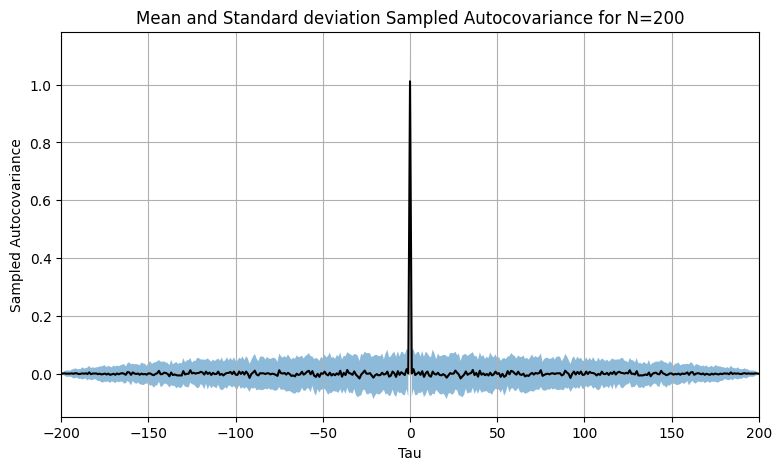

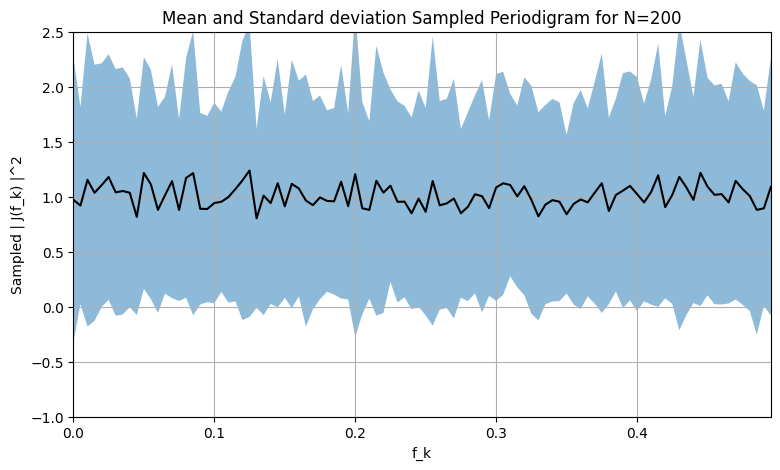

In [5]:
N = 200
plot_autocovariance_and_periodigram(N, n_simu, f_s)

N = 500

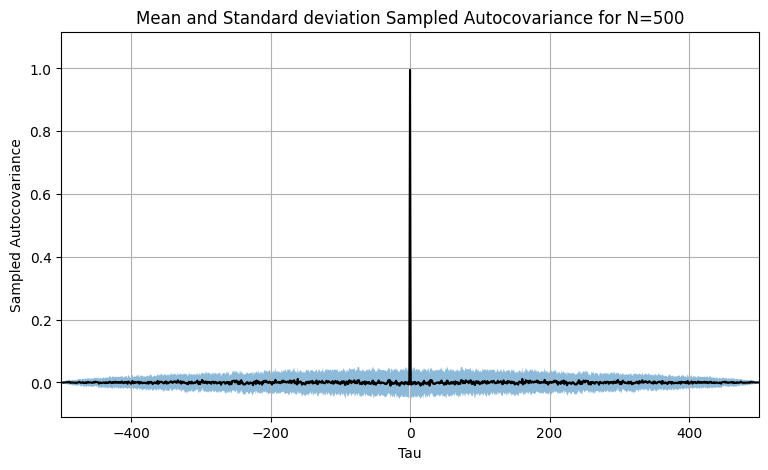

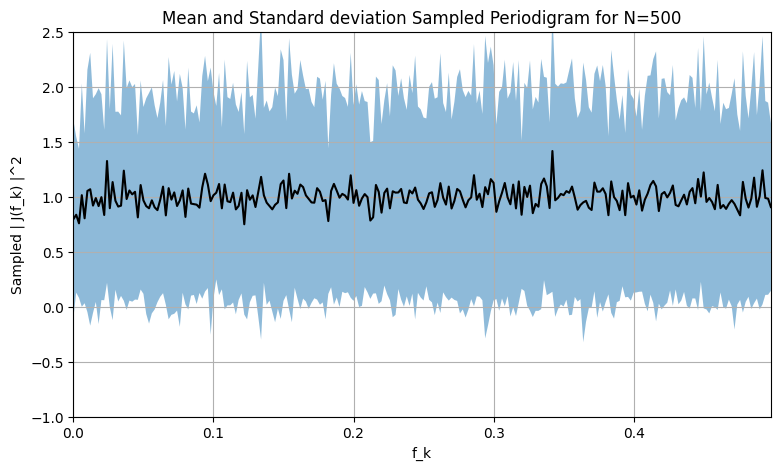

In [6]:
N = 500
plot_autocovariance_and_periodigram(N, n_simu, f_s)

N = 1000

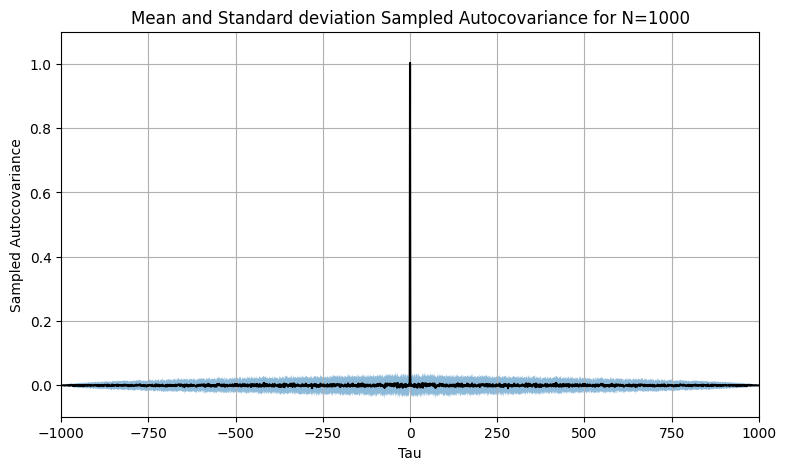

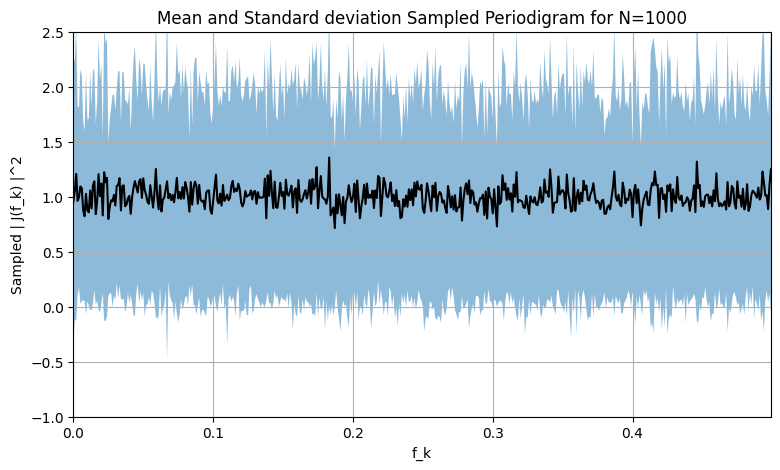

In [7]:
N = 1000
plot_autocovariance_and_periodigram(N, n_simu, f_s)

## Question 9

In [8]:
def compute_barlett_periodograms(N, n_simu, f_s, K):
    step = N // K
    _, _, _, freqs_periodograms = compute_autocov_and_perdiodograms(N, n_simu, f_s)

    periodograms_Barlett = np.zeros((n_simu, N // 2))

    for i in range(n_simu):
        x = np.random.normal(0, 1, N)

        for j, f in enumerate(freqs_periodograms):
            average_periodogram = 0

            for k in range(K):
                average_periodogram += J(x[k * step : (k + 1) * step], f, f_s) / K

            periodograms_Barlett[i, j] = average_periodogram
    return freqs_periodograms, periodograms_Barlett


def plot_barlett_perdiodogram(freqs_periodograms, periodograms_Barlett):
    _, ax = fig_ax(figsize=(9, 5))

    avg = periodograms_Barlett.mean(axis=0)
    std = periodograms_Barlett.std(axis=0)
    ax.plot(freqs_periodograms, avg, "k-")
    ax.fill_between(freqs_periodograms, avg - std, avg + std, alpha=0.5)
    ax.grid()
    ax.set_ylim(-1, 2.5)
    ax.set_title(f"Mean and Standard deviation Sampled Barlett Periodigram for N={N}")
    ax.set_xlabel("f_k")
    ax.set_ylabel("Sampled Barlett | J(f_k) |^2")
    plt.savefig(f"q6_Barlett_{N}.png", bbox_inches="tight")
    plt.show()

In [9]:
K = 5

N = 200

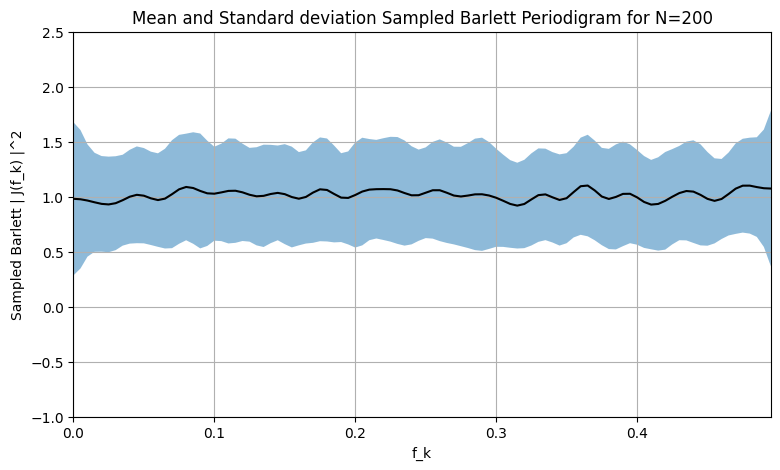

In [10]:
N = 200
freqs_periodograms, periodograms_Barlett = compute_barlett_periodograms(
    N, n_simu, f_s, K
)

plot_barlett_perdiodogram(freqs_periodograms, periodograms_Barlett)

N = 500

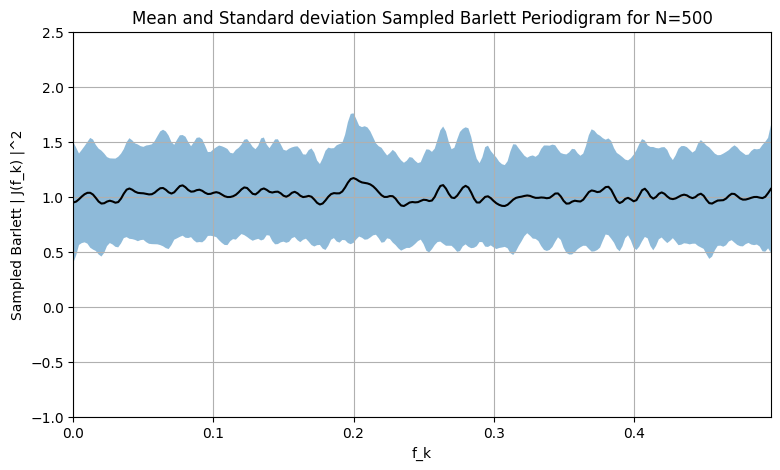

In [11]:
N = 500
freqs_periodograms, periodograms_Barlett = compute_barlett_periodograms(
    N, n_simu, f_s, K
)
plot_barlett_perdiodogram(freqs_periodograms, periodograms_Barlett)

N = 1000

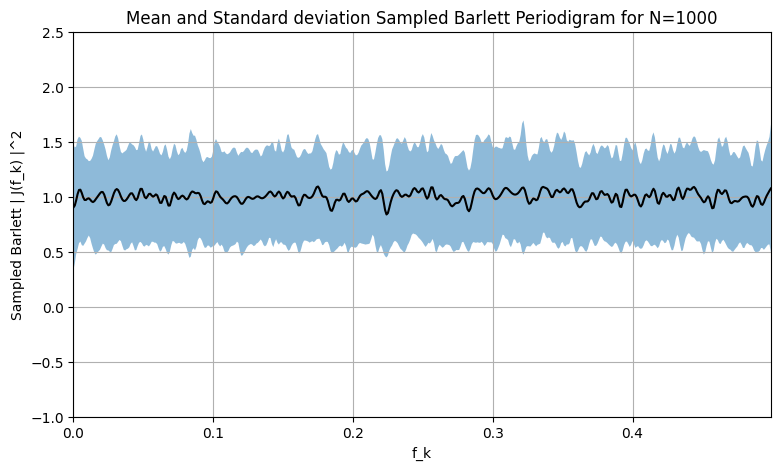

In [12]:
N = 1000
freqs_periodograms, periodograms_Barlett = compute_barlett_periodograms(
    N, n_simu, f_s, K
)
plot_barlett_perdiodogram(freqs_periodograms, periodograms_Barlett)

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [13]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
from dtw import dtw
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, recall_score
import matplotlib.patches as mpatches


def DTW(x1, x2):
    alignment = dtw(x1, x2)
    return alignment.distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



We first compute the DTW for the train and test dataset.

In [15]:
N_Train = len(X_train)
N_Test = len(X_test)

train_distance_matrix = np.zeros((N_Train, N_Train))
test_distance_matrix = np.zeros((N_Test, N_Train))

for i in range(N_Train):
    for j in range(N_Train):
        train_distance_matrix[i, j] = DTW(X_train[i], X_train[j])

for i in range(N_Test):
    for j in range(N_Train):
        test_distance_matrix[i, j] = DTW(X_test[i], X_train[j])

Let's plot the DTW distance in the training set.

(168, 88)

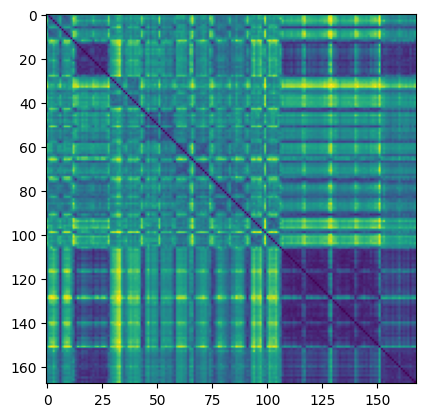

In [16]:
plt.imshow(train_distance_matrix)
N_Train, N_Test

The we perform KNN using this distance.

n = 2| F1-Score: 0.845 | Accuracy: 0.863 | Recall: 0.787
n = 3| F1-Score: 0.867 | Accuracy: 0.875 | Recall: 0.863
n = 4| F1-Score: 0.845 | Accuracy: 0.857 | Recall: 0.825
n = 5| F1-Score: 0.840 | Accuracy: 0.851 | Recall: 0.825
n = 6| F1-Score: 0.849 | Accuracy: 0.863 | Recall: 0.812
n = 7| F1-Score: 0.859 | Accuracy: 0.869 | Recall: 0.838
n = 8| F1-Score: 0.862 | Accuracy: 0.875 | Recall: 0.825
n = 9| F1-Score: 0.846 | Accuracy: 0.857 | Recall: 0.825
n = 10| F1-Score: 0.851 | Accuracy: 0.863 | Recall: 0.825
n = 11| F1-Score: 0.825 | Accuracy: 0.834 | Recall: 0.825
n = 12| F1-Score: 0.823 | Accuracy: 0.834 | Recall: 0.812
n = 13| F1-Score: 0.793 | Accuracy: 0.798 | Recall: 0.812
n = 14| F1-Score: 0.793 | Accuracy: 0.798 | Recall: 0.812
The best n is 3 with F1-Score 0.867, Accuracy 0.875, and Recall 0.863


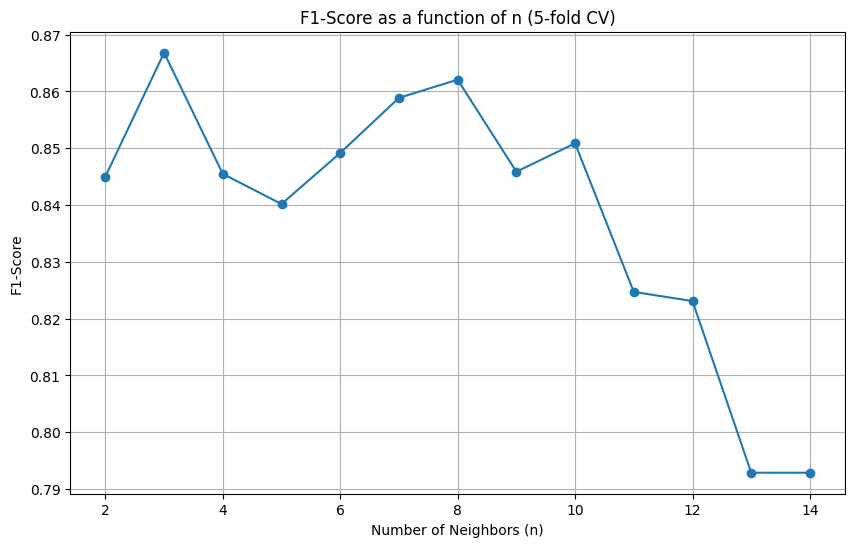

In [17]:
# Initialize arrays to store metrics
f1_scores = []
accuracy_scores = []
recall_scores = []
n_max = 15

# Initialize 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through n values
for n in range(2, n_max):
    knn = KNeighborsClassifier(n_neighbors=n, metric="precomputed")

    f1_cv = []
    acc_cv = []
    recall_cv = []

    for train_idx, test_idx in kf.split(train_distance_matrix, y_train):
        # print(train_idx,test_idx,y_train)
        X_train_cv, X_test_cv = (
            train_distance_matrix[train_idx][:, train_idx],
            train_distance_matrix[test_idx][:, train_idx],
        )
        y_train_cv, y_test_cv = (
            np.array(y_train)[train_idx],
            np.array(y_train)[test_idx],
        )

        knn.fit(X_train_cv, y_train_cv)

        y_pred = knn.predict(X_test_cv)

        f1 = f1_score(y_test_cv, y_pred)
        acc = accuracy_score(y_test_cv, y_pred)
        recall = recall_score(y_test_cv, y_pred)

        f1_cv.append(f1)
        acc_cv.append(acc)
        recall_cv.append(recall)

    f1_scores.append(np.mean(f1_cv))
    accuracy_scores.append(np.mean(acc_cv))
    recall_scores.append(np.mean(recall_cv))

    print(
        f"n = {n}| F1-Score: {np.mean(f1_cv):.3f} | Accuracy: {np.mean(acc_cv):.3f} | Recall: {np.mean(recall_cv):.3f}"
    )

# Find the best n and corresponding scores
best_n = np.argmax(f1_scores) + 2
best_f1 = f1_scores[best_n - 2]
best_acc = accuracy_scores[best_n - 2]
best_recall = recall_scores[best_n - 2]

print(
    f"The best n is {best_n} with F1-Score {best_f1:.3f}, Accuracy {best_acc:.3f}, and Recall {best_recall:.3f}"
)

# Plot F1-Score as function of n
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_max), f1_scores, marker="o")
plt.xlabel("Number of Neighbors (n)")
plt.ylabel("F1-Score")
plt.title("F1-Score as a function of n (5-fold CV)")
plt.grid(True)
plt.show()

We have found the best value for the KNN algorithm. Let's train it, and apply it to the test set.

In [18]:
# Train the model with the best n on the entire training set
best_knn = KNeighborsClassifier(n_neighbors=best_n, metric="precomputed")
best_knn.fit(train_distance_matrix, y_train)

# Predict on the real test set
y_pred_test = best_knn.predict(test_distance_matrix)

# Compute metrics on the real test set
f1_test = f1_score(y_test, y_pred_test)
acc_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

print(f"Metrics on the real test set with best n ({best_n}):")
print(f"F1-Score: {f1_test:.3f} | Accuracy: {acc_test:.3f} | Recall: {recall_test:.3f}")

Metrics on the real test set with best n (3):
F1-Score: 0.482 | Accuracy: 0.341 | Recall: 0.370


We will plot classification results with their K=3 nearest neighbours

For the training set

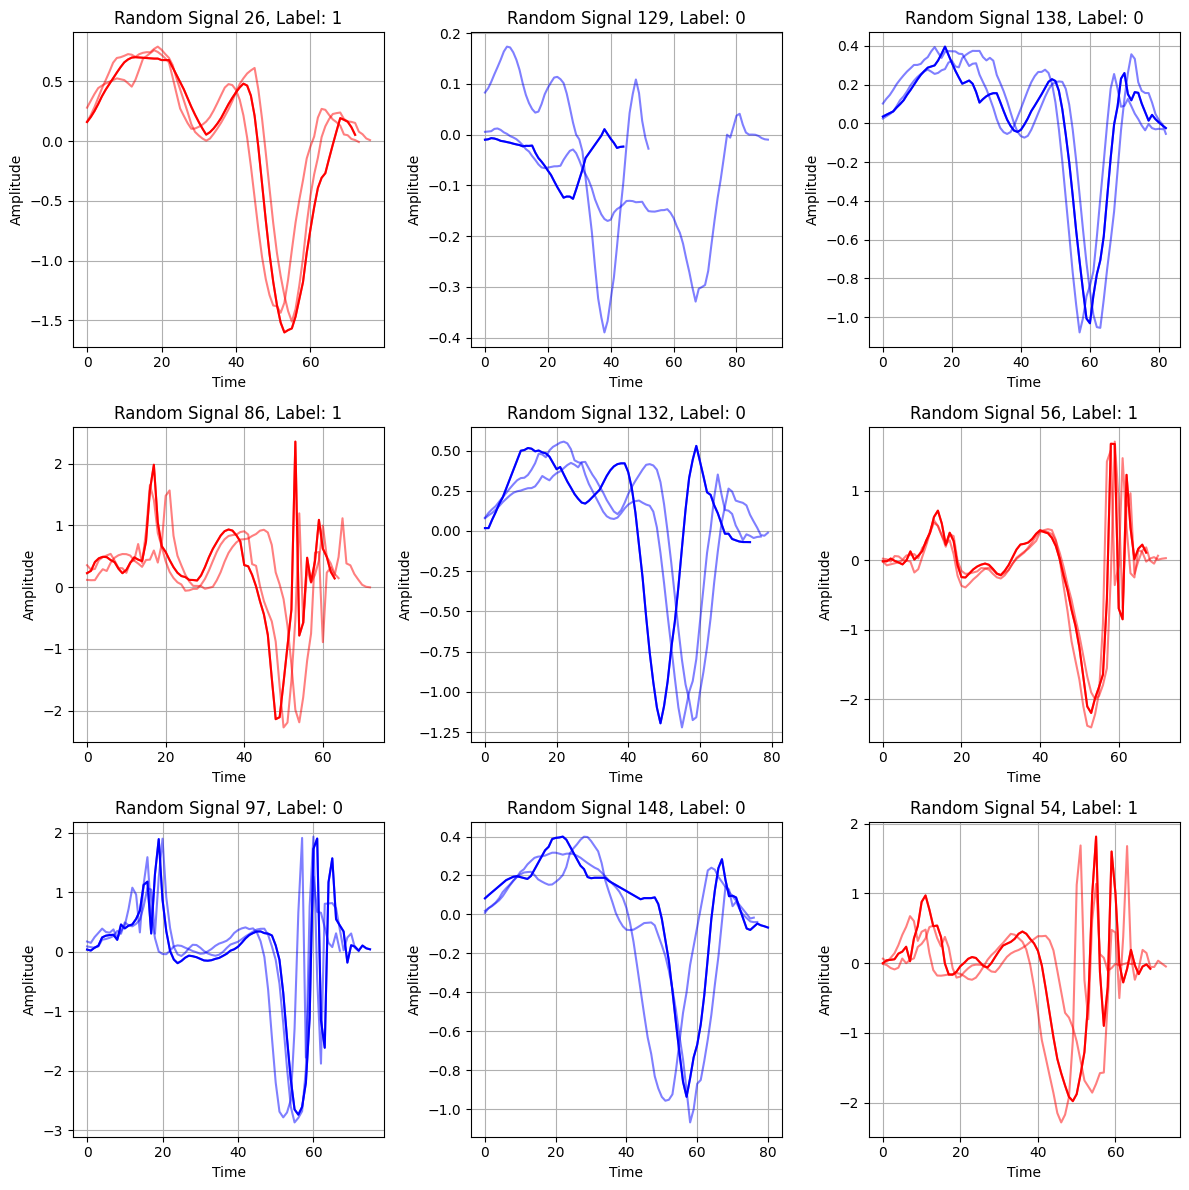

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()


# Loop through each subplot to plot random signals
for ax in axes:
    random_index = np.random.randint(0, len(X_train))

    # Plot the signal in blue or green depending on the label
    color = "b" if y_train[random_index] == 0 else "r"
    ax.plot(X_train[random_index], color=color)

    # Plot the best_n nearest neighbors in red (alpha=0.5)
    distances, indices = best_knn.kneighbors(
        [train_distance_matrix[random_index]], n_neighbors=best_n
    )
    for neighbor_index in indices[0]:
        color = "b" if y_train[random_index] == 0 else "r"
        ax.plot(X_train[neighbor_index], color=color, alpha=0.5)

    ax.set_title(f"Random Signal {random_index}, Label: {y_train[random_index]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

For the test set

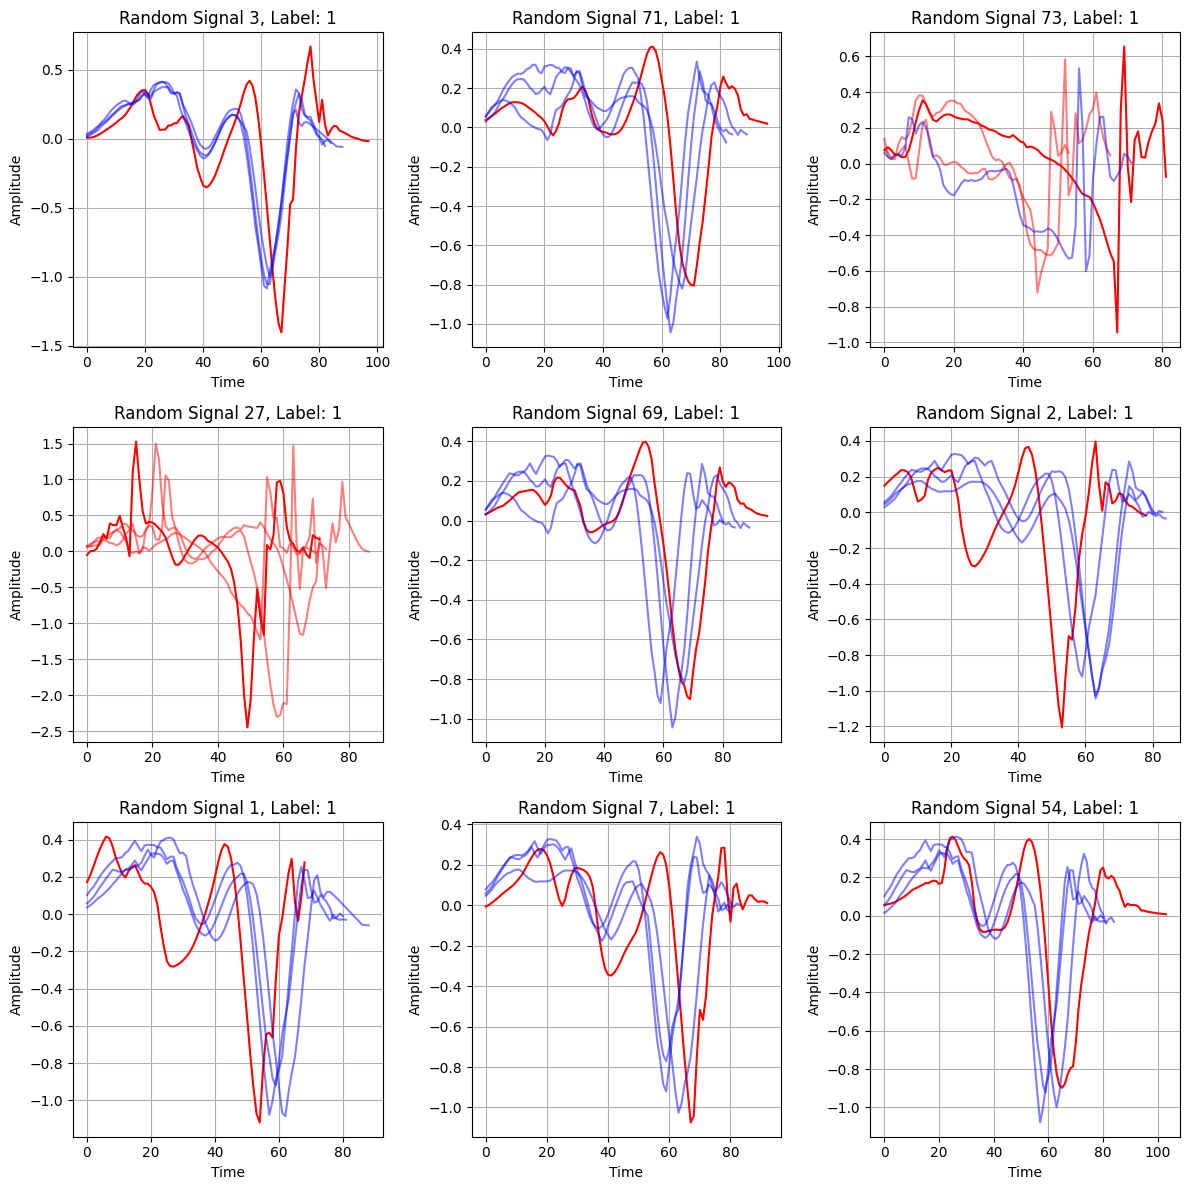

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()
# Loop through each subplot to plot random signals
for ax in axes:
    random_index = np.random.randint(0, len(X_test))

    # Plot the signal in blue or green depending on the label
    color = "b" if y_test[random_index] == 0 else "r"
    ax.plot(X_test[random_index], color=color)

    # Plot the best_n nearest neighbors in red (alpha=0.5)
    distances, indices = best_knn.kneighbors(
        [test_distance_matrix[random_index]], n_neighbors=best_n
    )
    for neighbor_index in indices[0]:
        color = "b" if y_train[neighbor_index] == 0 else "r"
        ax.plot(X_train[neighbor_index], color=color, alpha=0.5)

    ax.set_title(f"Random Signal {random_index}, Label: {y_test[random_index]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

## Question 11

Here are two signals, healthy and non-healthy. To understand the decision, we have represented the misclassified signal and its K=3 nearest neighbours.

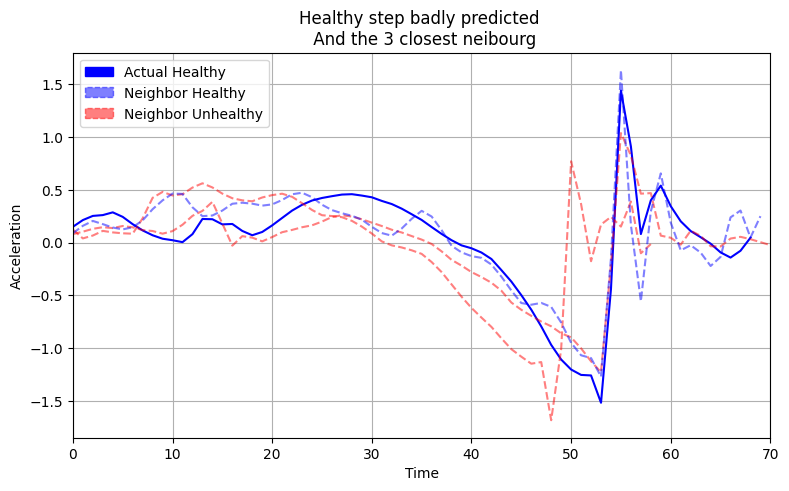

In [21]:
fig, ax = fig_ax(figsize=(9, 5))
for i in range(len(y_test)):
    # healthy badly predicted
    if y_test[i] == 0 and y_pred_test[i] == 1:
        # Plot the signal in blue or green depending on the label
        color = "b" if y_test[i] == 0 else "r"
        ax.plot(X_test[i], color=color)

        # Plot the best_n nearest neighbors in red (alpha=0.5)
        distances, indices = best_knn.kneighbors(
            [test_distance_matrix[i]], n_neighbors=best_n
        )
        for neighbor_index in indices[0]:
            color = "b--" if y_train[neighbor_index] == 0 else "r--"
            ax.plot(X_train[neighbor_index], color, alpha=0.5)

        ax.set_xlabel("Time")
        ax.set_ylabel("Acceleration")
        ax.grid(True)
        ax.set_title("Healthy step badly predicted \n And the 3 closest neibourg")
        blue_patch = mpatches.Patch(color="blue", label="Actual Healthy")
        blue_dashed_patch = mpatches.Patch(
            color="blue", linestyle="--", label="Neighbor Healthy", alpha=0.5
        )
        red_dashed_patch = mpatches.Patch(
            color="red", linestyle="--", label="Neighbor Unhealthy", alpha=0.5
        )
        ax.legend(handles=[blue_patch, blue_dashed_patch, red_dashed_patch])
        break

plt.savefig(f"q11_fail_healthy.png", bbox_inches="tight")

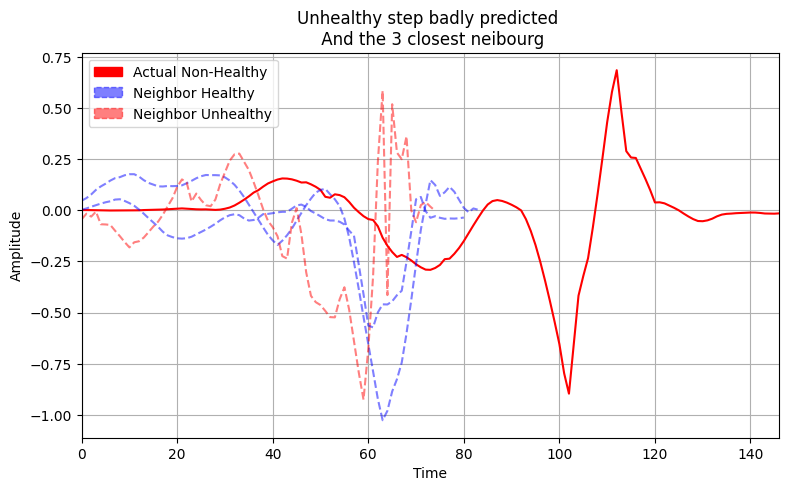

In [22]:
fig, ax = fig_ax(figsize=(9, 5))
for i in range(len(y_test)):
    # If its a class healthy badly predicted
    if y_test[i] == 1 and y_pred_test[i] == 0:
        # Extract the signal to display
        # Plot the signal in blue or green depending on the label
        color = "b" if y_test[i] == 0 else "r"
        ax.plot(X_test[i], color=color)

        # Plot the best_n nearest neighbors in red (alpha=0.5)
        distances, indices = best_knn.kneighbors(
            [test_distance_matrix[i]], n_neighbors=best_n
        )
        for neighbor_index in indices[0]:
            color = "b--" if y_train[neighbor_index] == 0 else "r--"
            ax.plot(X_train[neighbor_index], color, alpha=0.5)

        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        ax.set_title("Unhealthy step badly predicted \n And the 3 closest neibourg")
        red_patch = mpatches.Patch(color="red", label="Actual Non-Healthy")
        blue_dashed_patch = mpatches.Patch(
            color="blue", linestyle="--", label="Neighbor Healthy", alpha=0.5
        )
        red_dashed_patch = mpatches.Patch(
            color="red", linestyle="--", label="Neighbor Unhealthy", alpha=0.5
        )
        ax.legend(handles=[red_patch, blue_dashed_patch, red_dashed_patch])
        break

plt.savefig(f"q11_fail_nonhealthy.png", bbox_inches="tight")